In [1]:
import os
import sys
sys.path.append(os.getcwd() + '/src')
import numpy as np
import matplotlib.pyplot as plt
from utils import load, make_ref, get_clpoles, step_info, load_square_traj, load_8_traj, load_circle_J_traj
from simulation import Simulation, sim_closed_loop, tranjectory_sim
import system_data as sysdat
from system_data import Ad, Bd, Cd, Dd
from vis_data import triple_plot, triple_plot2, plot_poles, scatter_controllers, plot_pose
from project import project, Controller
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

### How the solver performed? 

In [3]:
all_controllers = load('data/controllers_solver-SCS_all.pkl')
print('Number of projects:', len(all_controllers))

Number of projects: 741


status
infeasible             40
optimal                98
optimal_inaccurate    603
Name: status, dtype: int64


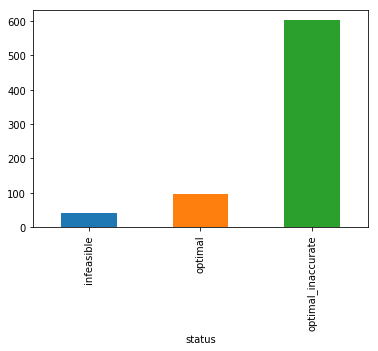

In [4]:
df = pd.DataFrame({'status': [c.status for c in all_controllers]})
df_g = df.groupby('status')['status'].count()
print(df_g)
df_g.plot.bar()

### How good is a controller that has poles freely alocated on the unit circle? 

In [5]:
q = 0.0
r = 0.99999
K, baseline_norm, P, status = project(Ad, Bd, Cd, Dd, q, r)

print('Optimization status:', status)
print('Minimal Hinf norm %.2f' % baseline_norm)


Optimization status: optimal
Minimal Hinf norm 17.71


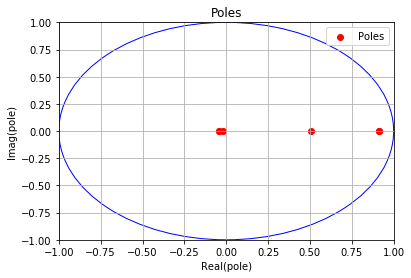

In [6]:
poles = get_clpoles(Ad, Bd, K)
plot_poles(poles, q, r)

How is it's transitory response?

In [7]:
ref = make_ref([0.6, 0, 0], 40)
states, control_signal, time = sim_closed_loop(ref, Simulation(sysdat.csys, sysdat.Ts), K)
info = step_info(time, states[:, 0])

baseline_u_max_var = np.max(np.abs(control_signal[:-1, :] - control_signal[1:, :]))
print('Max. Control Signal Var:', baseline_u_max_var)

Max. Control Signal Var: 6.894110475835012


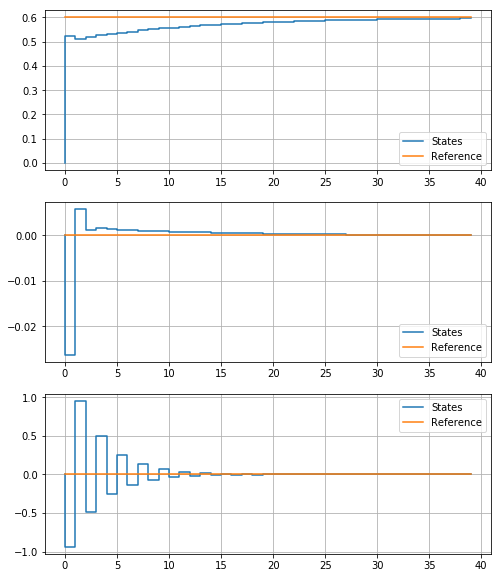

In [8]:
triple_plot2(states, ref, 'States', 'Reference', figsize=(8, 10))

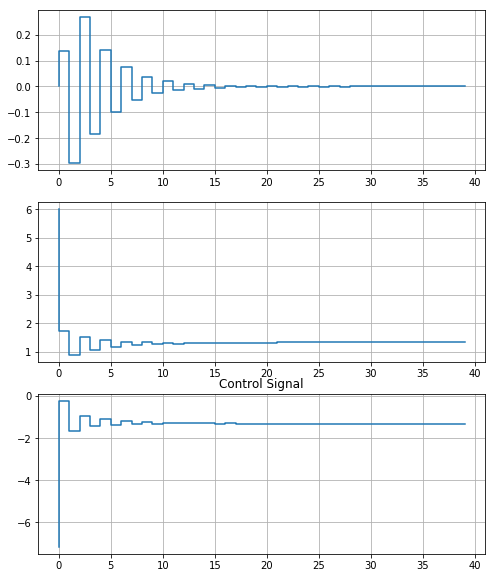

In [9]:
triple_plot(control_signal, 'Control Signal', figsize=(8, 10))

In [10]:
print(info)

RiseTime: 0.180
SettlingTime: 1.020
Overshoot: 0.018
PeakTime: 2.340


### Choosing a Controller
From controller data generated by running `project.py`

In [11]:
# def is_unstable(poles):
#     for pole in poles:
#         if np.abs(pole) >= 1:
#             return True
    
#     return False

# stable_controllers = [c for c in all_controllers if (not c.poles is None) and (not is_unstable(c.poles))]
# print('Stable Controlers:', len(stable_controllers))
# print('Unstable Controlers:', sum([is_unstable(c.poles) for c in all_controllers if not c.poles is None]))

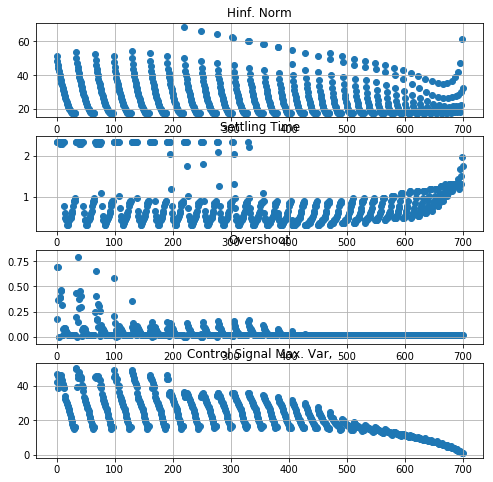

In [12]:
controllers = [c for c in all_controllers if not c.poles is None]

st = np.array([c.stepinfo.SettlingTime for c in controllers])
os = np.array([c.stepinfo.Overshoot for c in controllers])
u_var = np.array([c.u_max_var for c in controllers])
norm = np.array([c.norm for c in controllers])

arrs = [norm, st, os, u_var]
titles = ['Hinf. Norm', 'Settling Time', 'Overshoot', 'Control Signal Max. Var,']

scatter_controllers(arrs, titles)

Filtering:

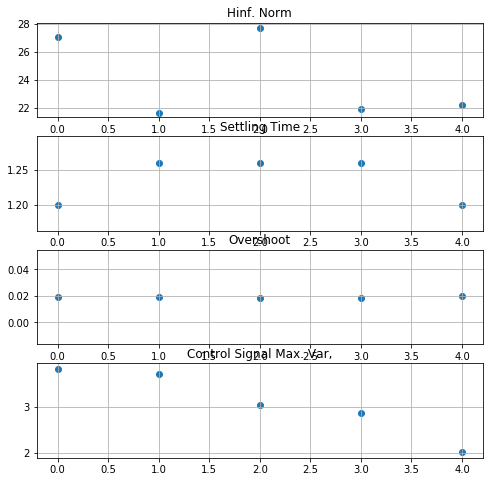

In [13]:
idx = np.where((st < 1.3) & (u_var < 4) & (norm < 30))[0]
filtered_arrs = [arr[idx] for arr in arrs]
scatter_controllers(filtered_arrs, titles)

Choosing the 2nd controller

In [14]:
c = controllers[idx[1]]
print(c)
print('Control Signal Max. Var.:', c.u_max_var)

Center: 0.80
Radius: 0.10
Hinf Norm: 21.64
Status: optimal_inaccurate
Poles: [0.85947942+0.j         0.85947942+0.j         0.75080054+0.j
 0.75080054+0.j         0.79948803+0.03967159j 0.79948803-0.03967159j]
Control Signal Max. Var.: 3.701985195839737


In [15]:
K = c.K
print(K)

[[ 5.25465145e-10  3.05631658e+00  8.67854892e-02 -6.03357162e-11
   5.06000672e-01 -1.69928975e-02]
 [-2.64684780e+00 -1.52815829e+00  8.67854892e-02 -4.38209436e-01
  -2.53000336e-01 -1.69928975e-02]
 [ 2.64684780e+00 -1.52815829e+00  8.67854892e-02  4.38209436e-01
  -2.53000336e-01 -1.69928975e-02]]


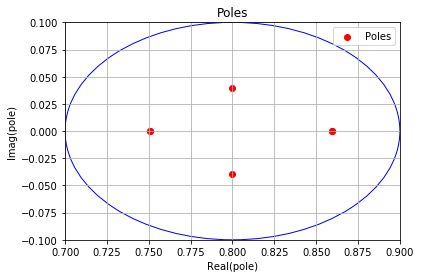

In [16]:
plot_poles(c.poles, c.q, c.r)

Assess system performance

In [17]:
ref = make_ref([0.6, 0, 0], 40)
states, control_signal, time = sim_closed_loop(ref, Simulation(sysdat.csys, sysdat.Ts), K)

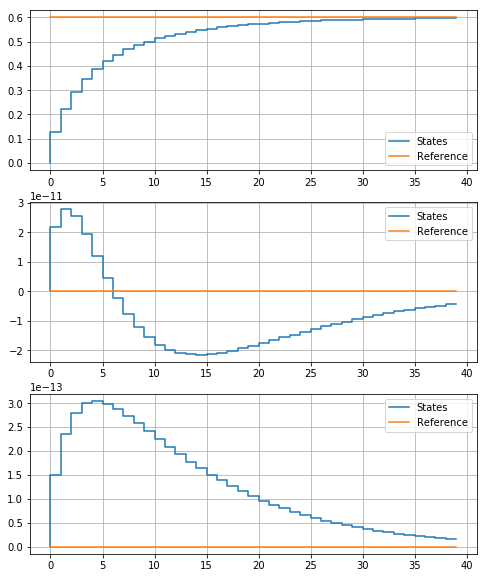

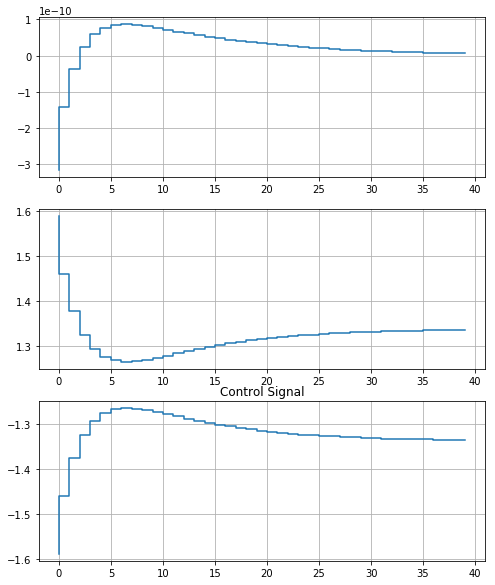

In [18]:
triple_plot2(states, ref, 'States', 'Reference', figsize=(8, 10))
triple_plot(control_signal, 'Control Signal', figsize=(8, 10))

Something wrong here

In [19]:
info_chosen = step_info(time, states[:, 0])
print('Chosen controller performance:')
print(info_chosen)

Chosen controller performance:
RiseTime: 0.660
SettlingTime: 1.260
Overshoot: 0.019
PeakTime: 2.340


In [20]:
print('Baseline controller performance:')
print(info)

Baseline controller performance:
RiseTime: 0.180
SettlingTime: 1.020
Overshoot: 0.018
PeakTime: 2.340


In [21]:
print('Reduction in control signal max. variation: %.2f%%' % ((baseline_u_max_var - c.u_max_var)/baseline_u_max_var * 100))
print('Increase in the Hinf. norm: %.2f%%' % ((c.norm - baseline_norm  )/baseline_norm * 100))

Reduction in control signal max. variation: 46.30%
Increase in the Hinf. norm: 22.22%


### Simulation 1: v_nav = 0.3

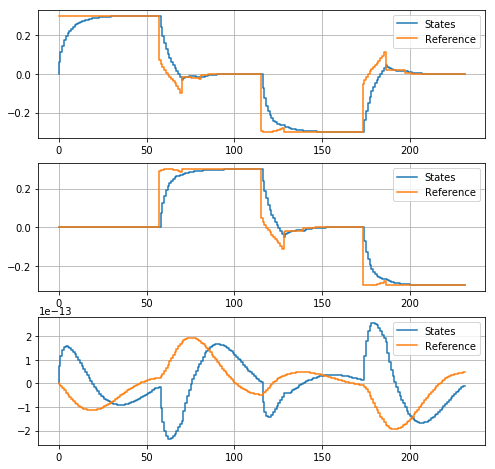

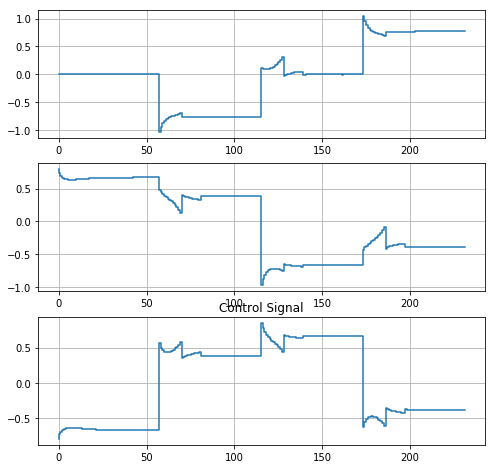

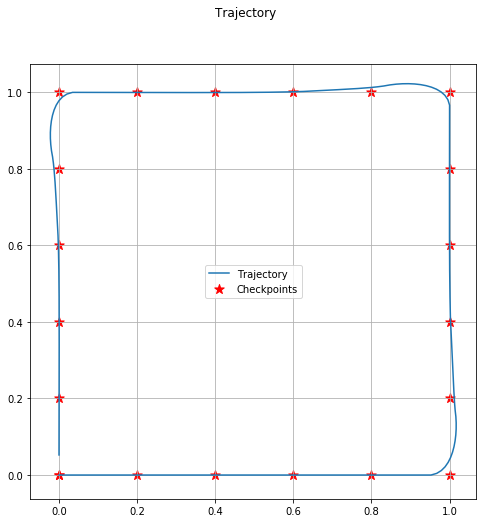

In [22]:
traj = load_square_traj()
states, control_signal, ref, pose = tranjectory_sim(traj, 0.3, Simulation(sysdat.csys, sysdat.Ts), K)

triple_plot2(states, ref, 'States', 'Reference')
triple_plot(control_signal, 'Control Signal')
plot_pose(pose, load_square_traj())

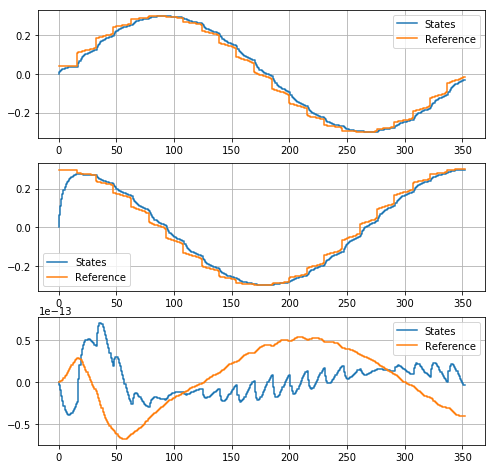

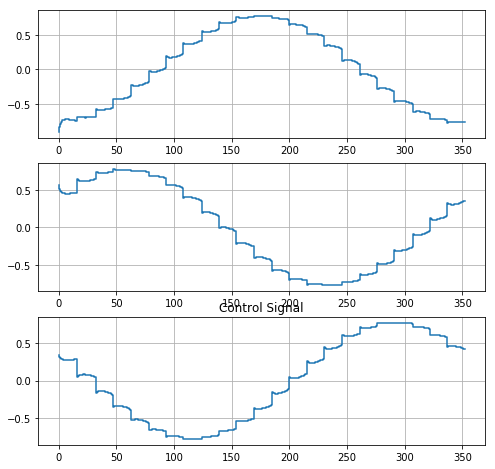

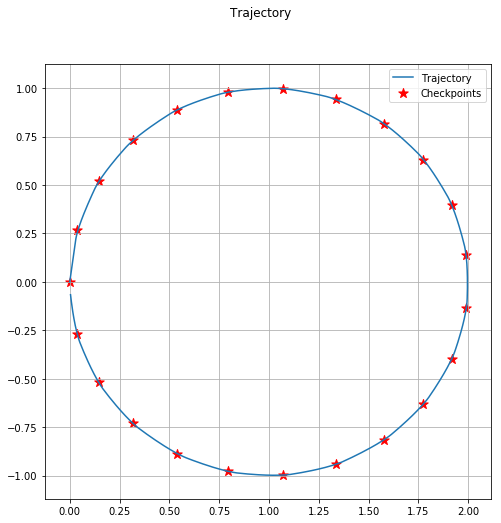

In [23]:
traj = load_circle_J_traj()
states, control_signal, ref, pose = tranjectory_sim(traj, 0.3, Simulation(sysdat.csys, sysdat.Ts), K)

triple_plot2(states, ref, 'States', 'Reference')
triple_plot(control_signal, 'Control Signal')
plot_pose(pose, traj)

### Simulation 2: v_nav = 0.6

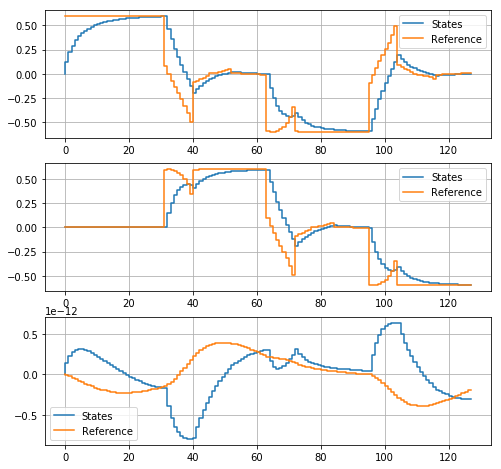

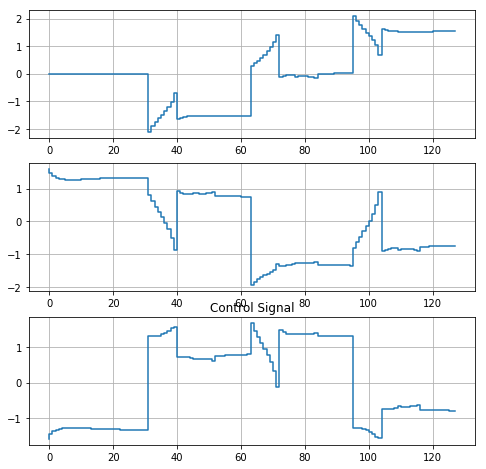

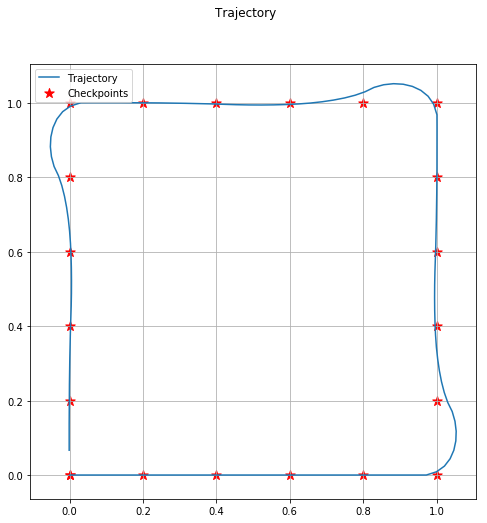

In [24]:
traj = load_square_traj()
states, control_signal, ref, pose = tranjectory_sim(traj, 0.6, Simulation(sysdat.csys, sysdat.Ts), K)

triple_plot2(states, ref, 'States', 'Reference')
triple_plot(control_signal, 'Control Signal')
plot_pose(pose, load_square_traj())

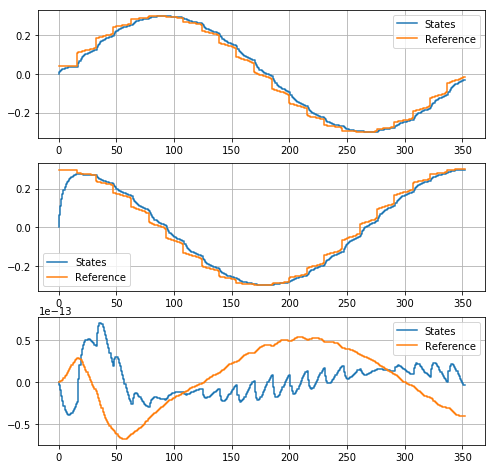

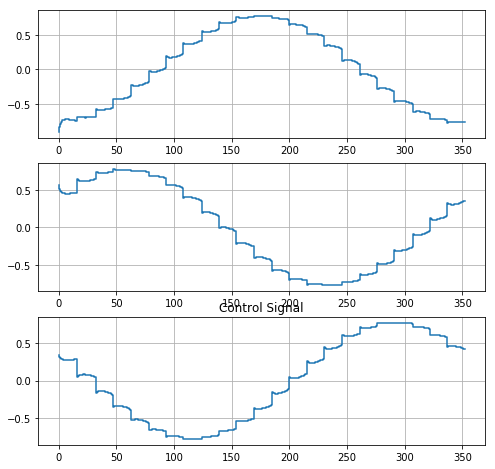

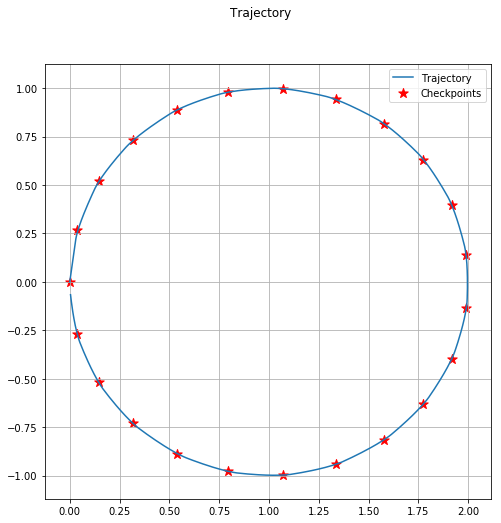

In [25]:
traj = load_circle_J_traj()
states, control_signal, ref, pose = tranjectory_sim(traj, 0.3, Simulation(sysdat.csys, sysdat.Ts), K)

triple_plot2(states, ref, 'States', 'Reference')
triple_plot(control_signal, 'Control Signal')
plot_pose(pose, traj)